# TABELLA PATTERN SELEZIONATI DA EURISTICA/RARI/COMUNI

In [1]:
"""
Script per:
1) caricare topk_riconteggio.csv in un PatternTable
2) selezionare pattern con l'euristica (o rari/comuni)
3) aggiungere la colonna Velocity
4) esportare in Excel i pattern selezionati con:
   - frequenza (p)
   - pattern in formato lista
   - entropia
   - entropia / entropia totale
   - Dinamicity (Velocity)
"""

from pathlib import Path
import pandas as pd

from motionpattern.pattern_table import (
    ImportData,
    apply_heuristic,
    apply_rari_match_info,
    apply_comuni_match_info,
    apply_rari_match_N_W,
    apply_comuni_match_N_W,
    add_velocity,
)

# ==========================================================
# PARAMETRI PRINCIPALI DA CAMBIARE IN BASE AI DATI
# ==========================================================

ROOT = Path().resolve().parents[0]

# File CSV con le probabilità p già stimate (topk_riconteggio.csv)
csv_path = ROOT / "examples" / "data" / "topk_riconteggio.csv"

# TimeFilter e SpaceFilter del dataset (es. 3×3×3)
TIME_FILTER = 3    # per pattern statici sarebbe 1
SPACE_FILTER = 3

# Parametri dell'euristica
MAX_N = 300        # numero massimo di pattern
MAX_W = 0.025     # banda massima consentita

# File Excel di output
xlsx_out = ROOT / "output" / f"pattern_selezionati_N_W_{MAX_N}_{MAX_W}.xlsx"

# ==========================================================
# 1) Importa il CSV in un PatternTable
# ==========================================================

table = ImportData(
    path=csv_path,
    real_counting=True,     # usa la colonna 'p' del file
    TimeFilter=TIME_FILTER,
    SpaceFilter=SPACE_FILTER,
)

print("Tabella caricata.")
table.print_info(masked=True)

# ==========================================================
# 2) Selezione pattern
#
# Di default: euristica su N e W.
# Se si vogliono pattern rari/comuni, si possono sostituire le righe
# con una delle funzioni sotto.
# ==========================================================

# --- euristica standard ---
table_sel = apply_heuristic(
    df=table,
    Max_W=MAX_W,
    Max_N=MAX_N,
    inplace=False,   # crea una copia, non modifica la tabella originale
)

# --- esempi alternativi (da usare al posto di apply_heuristic) ---
# pattern rari con match sull'informazione:
# table_sel, skipped = apply_rari_match_info(df=table, Max_W=MAX_W, Max_N=MAX_N, inplace=False)
#
# pattern comuni con match sull'informazione:
# table_sel, skipped = apply_comuni_match_info(df=table, Max_W=MAX_W, Max_N=MAX_N, inplace=False)
#
# pattern rari con vincoli diretti N, W:
# table_sel, skipped = apply_rari_match_N_W(df=table, Max_W=MAX_W, Max_N=MAX_N, inplace=False)
#
# pattern comuni con vincoli diretti N, W:
# table_sel, skipped = apply_comuni_match_N_W(df=table, Max_W=MAX_W, Max_N=MAX_N, inplace=False)

print("\nDopo selezione:")
table_sel.print_info(masked=True)

# ==========================================================
# 3) Aggiungi la colonna Velocity (definita solo se TimeFilter > 1)
# ==========================================================

add_velocity(table_sel, inplace=True)

# ==========================================================
# 4) Costruisci la tabella dei soli pattern selezionati e salvala in Excel
# ==========================================================

# Sottoinsieme dei pattern selezionati (Mask=True)
df_sel = table_sel[table_sel["Mask"]].copy()

# Pattern in formato lista (TimeFilter × SpaceFilter × SpaceFilter
# oppure SpaceFilter × SpaceFilter se TimeFilter == 1)
pattern_arrays = table_sel.get_PatternList(masked=True)
df_sel["Pattern_list"] = [arr.tolist() for arr in pattern_arrays]

# Seleziona e rinomina le colonne per l’Excel finale
df_excel = df_sel[["p", "Pattern_list", "Entropy", "EntropyRatio", "Velocity"]].copy()
df_excel = df_excel.rename(
    columns={
        "p": "Frequency",
        "Pattern_list": "Pattern_list",
        "Entropy": "Entropy",
        "EntropyRatio": "EntropyRatio",
        "Velocity": "Dinamicity",   
    }
)

# Crea cartella di output se non esiste
xlsx_out.parent.mkdir(parents=True, exist_ok=True)

# Salva in Excel, usando l'indice come PatternValue
df_excel.to_excel(xlsx_out, index_label="PatternValue")

print(f"\nFile Excel salvato in: {xlsx_out}")
print(f"Numero di pattern selezionati: {len(df_excel)}")


Tabella caricata.
Numero di pattern selezionati: 121890
Larghezza di banda (somma p): 0.915718
Entropia totale: 4.030601
Somma EntropyRatio: 1.000000

Dopo selezione:
Numero di pattern selezionati: 236
Larghezza di banda (somma p): 0.024951
Entropia totale: 0.228103
Somma EntropyRatio: 0.056593

File Excel salvato in: C:\Users\braua\Documents\TesiMagistrale\repository\Pattern-Motion-Project\output\pattern_selezionati_N_W_300_0.025.xlsx
Numero di pattern selezionati: 236


# PATTERN STATICI TRA QUELLI SELEZIONATI DALL'EURISTICA CON N = 300, W = 0.025


## TROVO I PATTERN

In [6]:
from pathlib import Path
from motionpattern.pattern_table import ImportData, apply_heuristic, is_static

# Root del progetto (notebook in notebooks/, progetto una cartella sopra)
ROOT = Path().resolve().parents[0]

# File di probabilità reali dei pattern
CSV_PATH = ROOT / "examples" / "data" / "topk_riconteggio.csv"

# Parametri dell’euristica
MAX_N = 300      # numero massimo di pattern
MAX_W = 0.025    # banda massima (somma p) consentita


# ==========================================================
# 1) Import: CSV -> PatternTable
# ==========================================================
# - real_counting=True: usa la colonna 'p' del file
# - TimeFilter/SpaceFilter: specificati a mano (necessari in questo caso)
table = ImportData(
    path=CSV_PATH,
    real_counting=True,
    TimeFilter=3,
    SpaceFilter=3,
)

# ==========================================================
# 2) Selezione con euristica (Mask aggiornata su una copia)
# ==========================================================
table_eu = apply_heuristic(
    df=table,
    Max_W=MAX_W,
    Max_N=MAX_N,
    inplace=False,   # NON modifica 'table', lavora su una copia
)

# PatternValue dei pattern selezionati (Mask=True)
pattern_selezionati_euristica = list(
    table_eu.get_PatternsValue(masked=True)
)

# ==========================================================
# 3) Separazione in pattern statici / dinamici
# ==========================================================
# is_static(pattern_value, TimeFilter, SpaceFilter)
pattern_statici = [
    patt
    for patt in pattern_selezionati_euristica
    if is_static(patt, TimeFilter=3, SpaceFilter=3)
]

pattern_dinamici = [
    patt
    for patt in pattern_selezionati_euristica
    if not is_static(patt, TimeFilter=3, SpaceFilter=3)
]

print(f"Totale selezionati (euristica): {len(pattern_selezionati_euristica)}")
print(f"  - statici : {len(pattern_statici)}")
print(f"  - dinamici: {len(pattern_dinamici)}")


Totale selezionati (euristica): 236
  - statici : 27
  - dinamici: 209


## GENERAZIONE SKETCH

### STATICI

In [8]:
from motionpattern.sketch_generator import *
import time

patterns = pattern_statici

# Notebook in notebooks/, root del progetto una cartella sopra
ROOT = Path().resolve().parents[0]
DATA_DIR = ROOT / "examples" / "data"

# Cartella con i video già binarizzati
INPUT_DIR = Path(r"C:\Users\braua\Documents\TesiMagistrale\DATASET_RIPULITO\VIDEO_BINARIZZATI")
OUTPUT_DIR = ROOT / "output" / "sketches" /"N_W_300_0.025_SOLO_STATICI"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)



# 4) Loop su tutti i video binari nella cartella
for path_in in INPUT_DIR.glob("*.avi"):
    path_out = OUTPUT_DIR / f"N_W_300_0.025_SOLO_STATICI_{path_in.stem}.avi"

    print(f"Elaboro: {path_in.name} → {path_out.name}")

    sk = SketchGenerator(
        path_in=path_in,
        path_out=path_out,
        list_patterns=patterns,
        TimeFilter=3,
        SpaceFilter=3,
    )

    MAX_TENTATIVI = 10
    stats = None

    for tentativo in range(1, MAX_TENTATIVI + 1):
        try:
            stats = sk.generate(lossless=True, verbose=1)
            break   # se va bene, esce dal ciclo
        except Exception as e:
            print(f"Tentativo {tentativo} fallito: {e}")
            if tentativo < MAX_TENTATIVI:
                print("Riprovo tra 10 secondi...")
                time.sleep(10)
            else:
                raise   # all'ultimo tentativo propaghi l'errore

    print("  ratio:", stats["ratio"])
    print("  pattern_totali:", stats["pattern_totali"])

Elaboro: 0.avi → N_W_300_0.025_SOLO_STATICI_0.avi
-------------------
Elaborazione completata, video salvato in: C:\Users\braua\Documents\TesiMagistrale\repository\Pattern-Motion-Project\output\sketches\N_W_300_0.025_SOLO_STATICI\N_W_300_0.025_SOLO_STATICI_0.avi.
87 frame processati, banda: 0.000.
  ratio: 0.00023118946122287448
  pattern_totali: 19871148
Elaboro: 1.avi → N_W_300_0.025_SOLO_STATICI_1.avi
-------------------
Elaborazione completata, video salvato in: C:\Users\braua\Documents\TesiMagistrale\repository\Pattern-Motion-Project\output\sketches\N_W_300_0.025_SOLO_STATICI\N_W_300_0.025_SOLO_STATICI_1.avi.
87 frame processati, banda: 0.002.
  ratio: 0.0022689177293631953
  pattern_totali: 19871148
Elaboro: 10.avi → N_W_300_0.025_SOLO_STATICI_10.avi
-------------------
Elaborazione completata, video salvato in: C:\Users\braua\Documents\TesiMagistrale\repository\Pattern-Motion-Project\output\sketches\N_W_300_0.025_SOLO_STATICI\N_W_300_0.025_SOLO_STATICI_10.avi.
87 frame processat

### SOLO DINAMICI

In [ ]:
from motionpattern.sketch_generator import *
import time

patterns = pattern_statici

# Notebook in notebooks/, root del progetto una cartella sopra
ROOT = Path().resolve().parents[0]
DATA_DIR = ROOT / "examples" / "data"

# Cartella con i video già binarizzati
INPUT_DIR = Path(r"C:\Users\braua\Documents\TesiMagistrale\DATASET_RIPULITO\VIDEO_BINARIZZATI")
OUTPUT_DIR = ROOT / "output" / "sketches" /"N_W_300_0.025_SOLO_DINAMICI"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)



# 4) Loop su tutti i video binari nella cartella
for path_in in INPUT_DIR.glob("*.avi"):
    path_out = OUTPUT_DIR / f"N_W_300_0.025_SOLO_DINAMICI_{path_in.stem}.avi"

    print(f"Elaboro: {path_in.name} → {path_out.name}")

    sk = SketchGenerator(
        path_in=path_in,
        path_out=path_out,
        list_patterns=patterns,
        TimeFilter=3,
        SpaceFilter=3,
    )

    MAX_TENTATIVI = 10
    stats = None

    for tentativo in range(1, MAX_TENTATIVI + 1):
        try:
            stats = sk.generate(lossless=True, verbose=1)
            break   # se va bene, esce dal ciclo
        except Exception as e:
            print(f"Tentativo {tentativo} fallito: {e}")
            if tentativo < MAX_TENTATIVI:
                print("Riprovo tra 10 secondi...")
                time.sleep(10)
            else:
                raise   # all'ultimo tentativo propaghi l'errore

    print("  ratio:", stats["ratio"])
    print("  pattern_totali:", stats["pattern_totali"])

## SPEZZETTAMENTO SKETCH

### SOLO STATICI

In [ ]:
from pathlib import Path
from motionpattern.spezzetta_sketch import spezzetta_sketch


folder_bin = Path(r"C:\Users\braua\Documents\TesiMagistrale\DATASET_RIPULITO\VIDEO_BINARIZZATI")
folder_sketch = ROOT / "output" / "sketches" /"N_W_300_0.025_SOLO_STATICI"

out_folder_bin = ROOT / "output" / "spzezzati"/ "DIGITALIZED_300_0.025_SOLO_STATICI"
out_folder_sketch = ROOT / "output" / "spzezzati"/"NON_OTTIMALI" / "SKETCH_300_0.025_SOLO_STATICI"

spezzetta_sketch(
    folder_bin=folder_bin,
    folder_sketch=folder_sketch,
    out_folder_bin=out_folder_bin,
    out_folder_sketch=out_folder_sketch,
    bin_prefix="",                     
    sketch_prefix="N_W_300_0.025_SOLO_STATICI_",  
    out_bin_prefix="Digitalized_STATICI_300_0.025_SOLO_STATICI",
    out_sketch_prefix="Sketch_STATICI_300_0.025_SOLO_STATICI",
    len_sketch=3,
    extra=2,
    padding=15,
    seed=None,
)

### SOLO DINAMICI

In [ ]:
from pathlib import Path
from motionpattern.spezzetta_sketch import spezzetta_sketch


folder_bin = Path(r"C:\Users\braua\Documents\TesiMagistrale\DATASET_RIPULITO\VIDEO_BINARIZZATI")
folder_sketch = ROOT / "output" / "sketches" /"N_W_300_0.025_SOLO_DINAMICI"

out_folder_bin = ROOT / "output" / "spzezzati"/ "DIGITALIZED_300_0.025_SOLO_DINAMICI"
out_folder_sketch = ROOT / "output" / "spzezzati"/"NON_OTTIMALI" / "SKETCH_300_0.025_SOLO_DINAMICI"

spezzetta_sketch(
    folder_bin=folder_bin,
    folder_sketch=folder_sketch,
    out_folder_bin=out_folder_bin,
    out_folder_sketch=out_folder_sketch,
    bin_prefix="",                     
    sketch_prefix="N_W_300_0.025_SOLO_DINAMICI_",  
    out_bin_prefix="Digitalized_STATICI_300_0.025_SOLO_DINAMICI",
    out_sketch_prefix="Sketch_STATICI_300_0.025_SOLO_DINAMICI",
    len_sketch=3,
    extra=2,
    padding=15,
    seed=None,
)

# TABELLA RARI-COMUNI MATCH: INFO-NW

In [16]:
from pathlib import Path
import pandas as pd

from motionpattern.pattern_table import (
    ImportData,
    apply_heuristic,
    apply_rari_match_info,
    apply_comuni_match_info,
    apply_rari_match_N_W,
    apply_comuni_match_N_W,
    add_velocity,
    PatternTable,
)

# ==========================================================
# PARAMETRI PRINCIPALI DA CAMBIARE IN BASE AI DATI
# ==========================================================

ROOT = Path().resolve().parents[0]

# File CSV con le probabilità p già stimate (topk_riconteggio.csv)
csv_path = ROOT / "examples" / "data" / "topk_riconteggio.csv"


# Parametri dell'euristica
MAX_N = 300        # numero massimo di pattern
MAX_W = 0.025     # banda massima consentita

# File Excel di output
xlsx_out = ROOT / "output" / f"pattern_non_ottimali_N_W_{MAX_N}_{MAX_W}.xlsx"

# ==========================================================
# 1) Importa il CSV in un PatternTable
# ==========================================================

table = ImportData(
    path=csv_path,
    real_counting=True,     # usa la colonna 'p' del file
    TimeFilter=3,
    SpaceFilter=3,
)
#prendo i primi 100k pattern
table.sort_values(by="p", ascending=False, inplace=True)
table = PatternTable(table[:100000])

table_eu = apply_heuristic(df=table, Max_W=MAX_W, Max_N=MAX_N, inplace=False)
table_rari_match_info, skipped = apply_rari_match_info(df=table, Max_W=MAX_W, Max_N=MAX_N, inplace=False)
table_rari_match_N_W, skipped= apply_rari_match_N_W(df=table, Max_W=MAX_W, Max_N=MAX_N, inplace=False)
table_comuni_match_info, skipped = apply_comuni_match_info(df=table, Max_W=MAX_W, Max_N=MAX_N, inplace=False)
table_comuni_match_N_W, skipped = apply_comuni_match_N_W(df=table, Max_W=MAX_W, Max_N=MAX_N, inplace=False)

lista_bande = [ table_rari_match_info.get_BandWidth(), table_rari_match_N_W.get_BandWidth(), table_comuni_match_info.get_BandWidth(), table_comuni_match_N_W.get_BandWidth() ]
lista_N = [ table_rari_match_info.get_N(), table_rari_match_N_W.get_N(), table_comuni_match_info.get_N(), table_comuni_match_N_W.get_N() ]
lista_Entropy = [ table_rari_match_info.get_Entropy(), table_rari_match_N_W.get_Entropy(), table_comuni_match_info.get_Entropy(), table_comuni_match_N_W.get_Entropy() ]
lista_Entropy_ratio = [ table_rari_match_info.get_EntropyRatio(), table_rari_match_N_W.get_EntropyRatio(), table_comuni_match_info.get_EntropyRatio(), table_comuni_match_N_W.get_EntropyRatio() ]

lista_selection = ["Rare", "Rare", "Common", "Common"]
lista_costraints = ["Entropy", "(W,N)", "Entropy", "(W,N)"]
columns = ["Selection", "Costraint", "N", "W", "Entropy", "Normalized Entropy"]


# --------------------------------------------------
# Costruzione tabella LaTeX
# --------------------------------------------------

lines = []

# intestazione tabella (qui uso booktabs; se non lo usi, sostituisci con \hline)
lines.append(r"\begin{tabular}{llrrrr}")
lines.append(r"\hline")
lines.append(" & ".join(columns) + r" \\")
lines.append(r"\hline")

for sel, cst, N, W, H, Hnorm in zip(
    lista_selection,
    lista_costraints,
    lista_N,
    lista_bande,
    lista_Entropy,
    lista_Entropy_ratio,
):
    line = (
        f"{sel} & {cst} & "
        f"{int(N)} & "
        f"{W:.8f} & "
        f"{H:.8f} & "
        f"{Hnorm:.8f} \\\\"
    )
    lines.append(line)

lines.append(r"\hline")
lines.append(r"\end{tabular}")

latex_table = "\n".join(lines)
print(latex_table)

\begin{tabular}{llrrrr}
\hline
Selection & Costraint & N & W & Entropy & Normalized Entropy \\
\hline
Rare & Entropy & 57202 & 0.01522061 & 0.22809862 & 0.05659171 \\
Rare & (W,N) & 300 & 0.00001709 & 0.00028515 & 0.00007075 \\
Common & Entropy & 6 & 0.04723104 & 0.22350768 & 0.05545269 \\
Common & (W,N) & 2 & 0.02117020 & 0.09628849 & 0.02388936 \\
\hline
\end{tabular}


In [19]:
table_eu.print_info()

Numero di pattern selezionati: 236
Larghezza di banda (somma p): 0.024951
Entropia totale: 0.228103
Somma EntropyRatio: 0.056593


# ISTOGRAMMA PATTERN-RARI COMUNI

### MATCH INFO

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


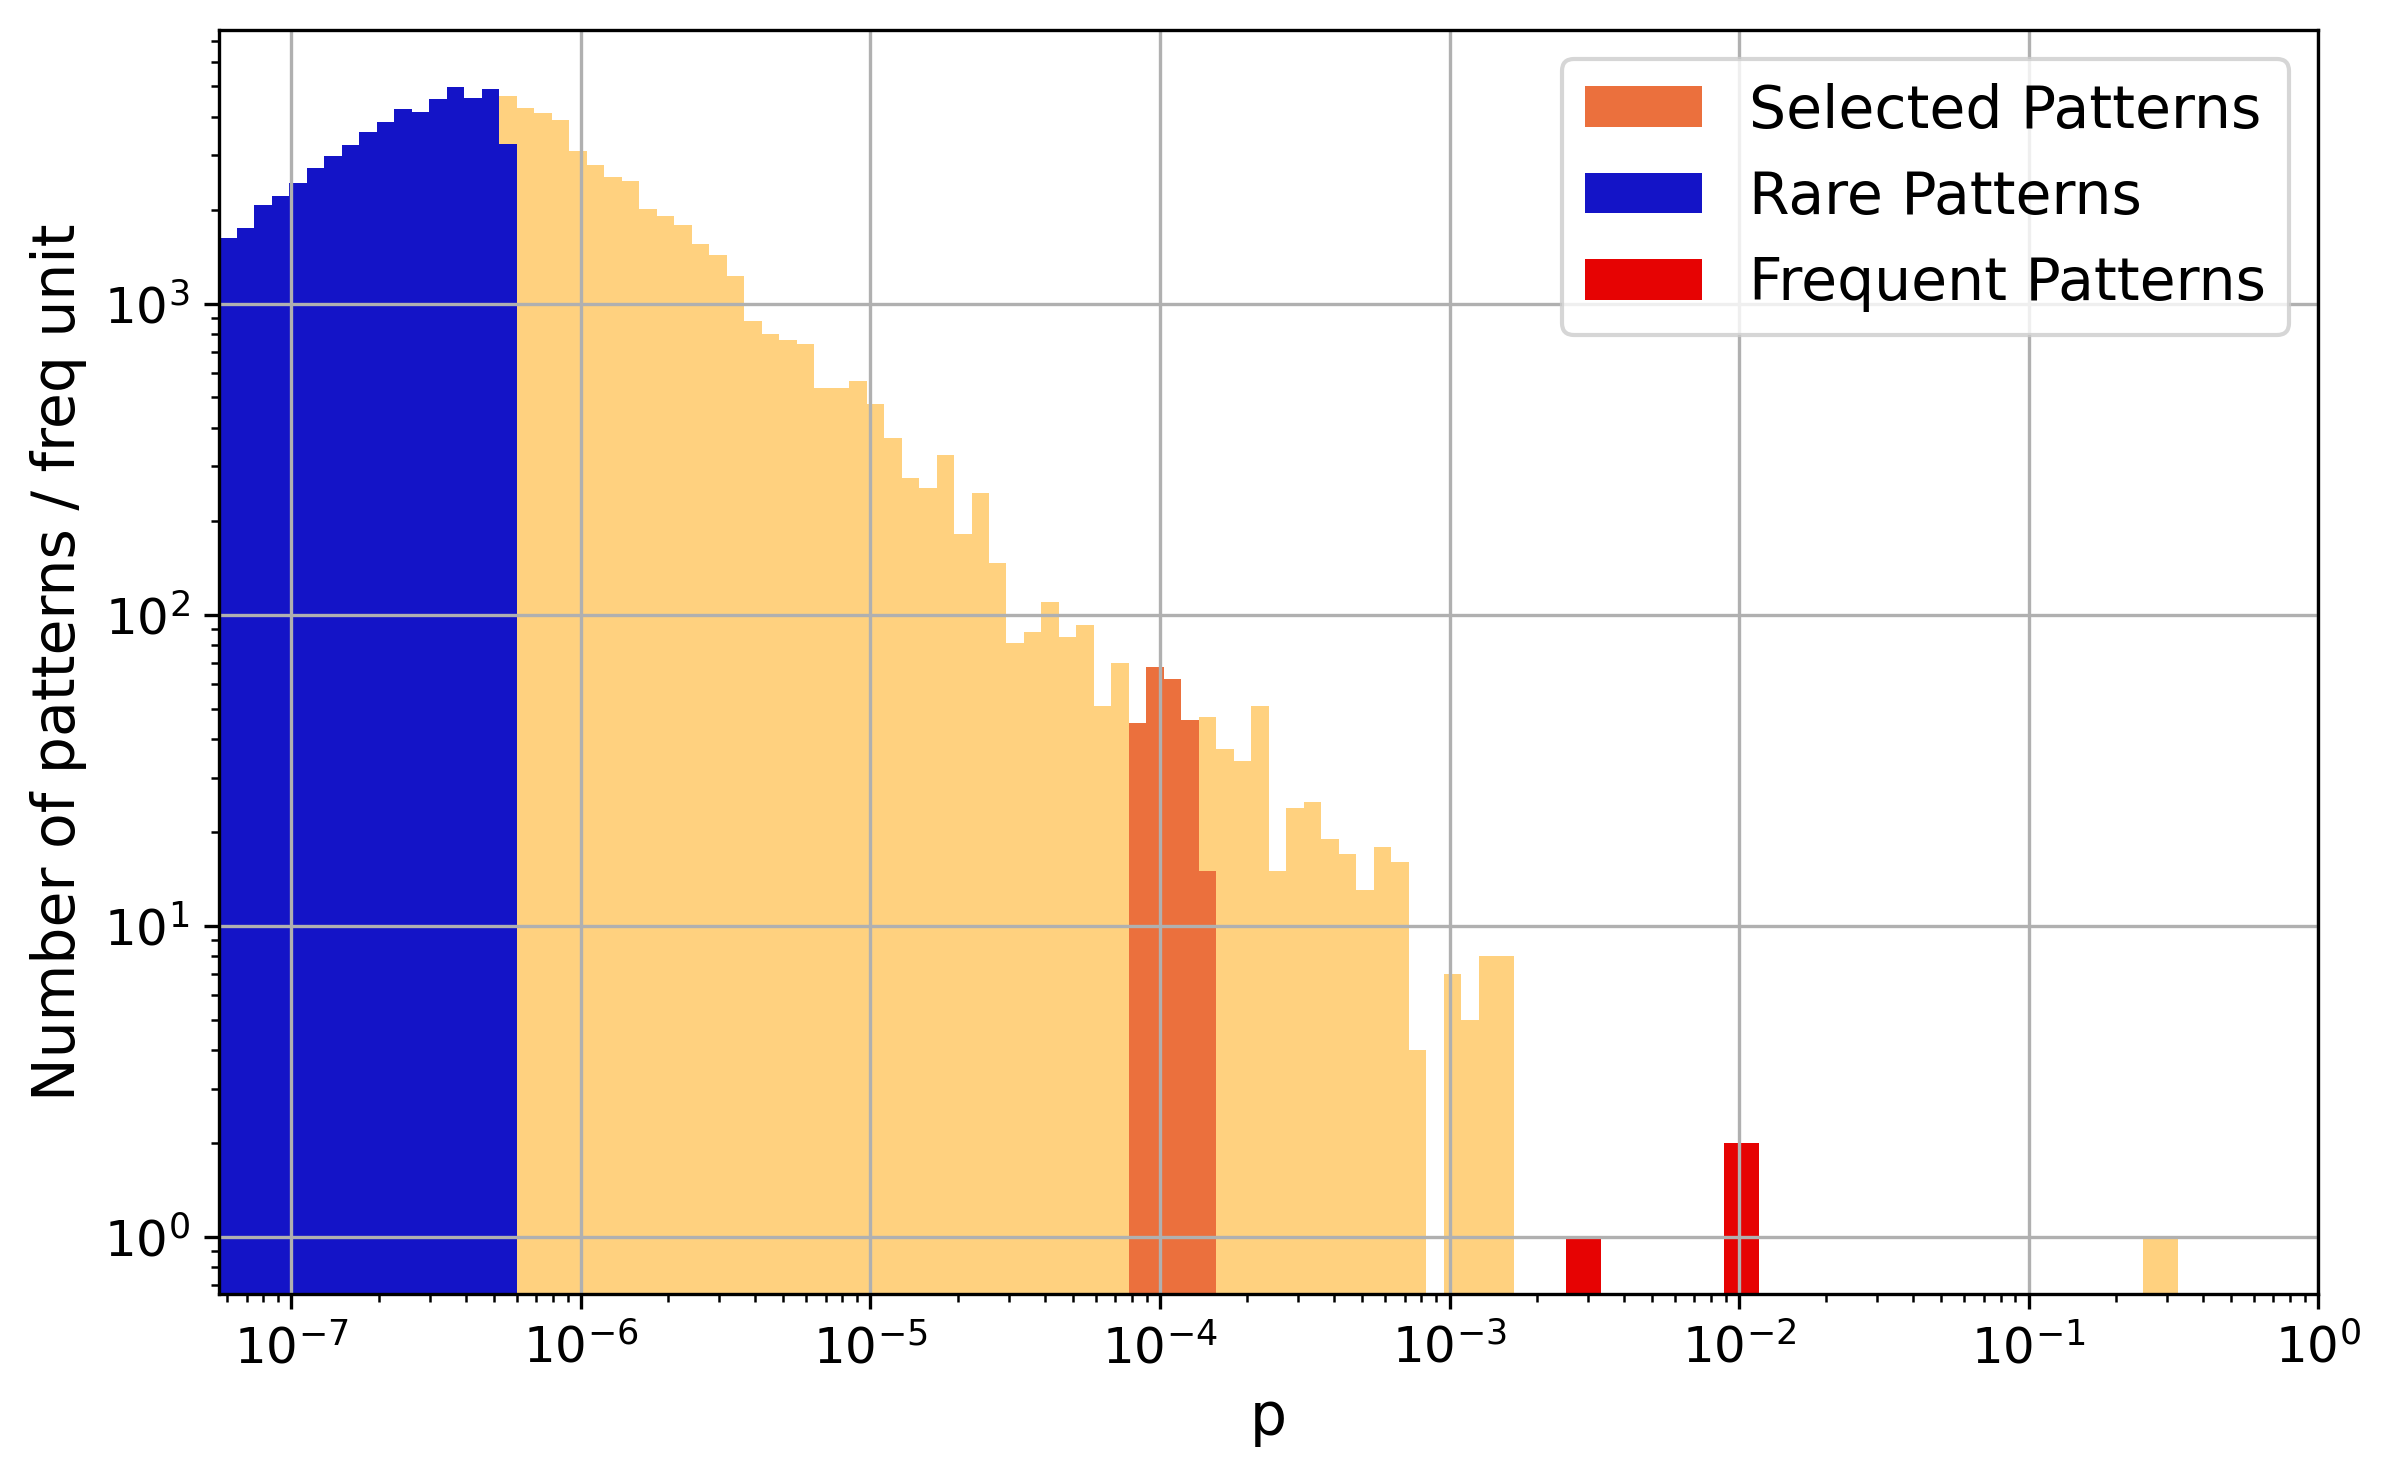

In [20]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 5), dpi=300)
bins = np.logspace(-9,0,150)

plt.hist(table["p"], bins = bins,alpha=0.5, color='orange')
plt.hist(table_eu[table_eu["Mask"]]["p"], bins =bins, color = "#eb703d", label = "Selected Patterns")
plt.hist(table_rari_match_info[table_rari_match_info["Mask"]]["p"], bins =bins, color = "#1414c7", label = "Rare Patterns")
plt.hist(table_comuni_match_info[table_comuni_match_info["Mask"]]["p"], bins =bins, color = "#e60303", label = "Frequent Patterns")
plt.xscale('log')
plt.yscale("log")
plt.xlabel("p", fontsize=14)
plt.ylabel("Number of patterns / freq unit", fontsize=14)
plt.xlim(table["p"].min(),1)
plt.grid(True)
plt.tight_layout()
plt.legend(fontsize = 14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

### MATCH N_W

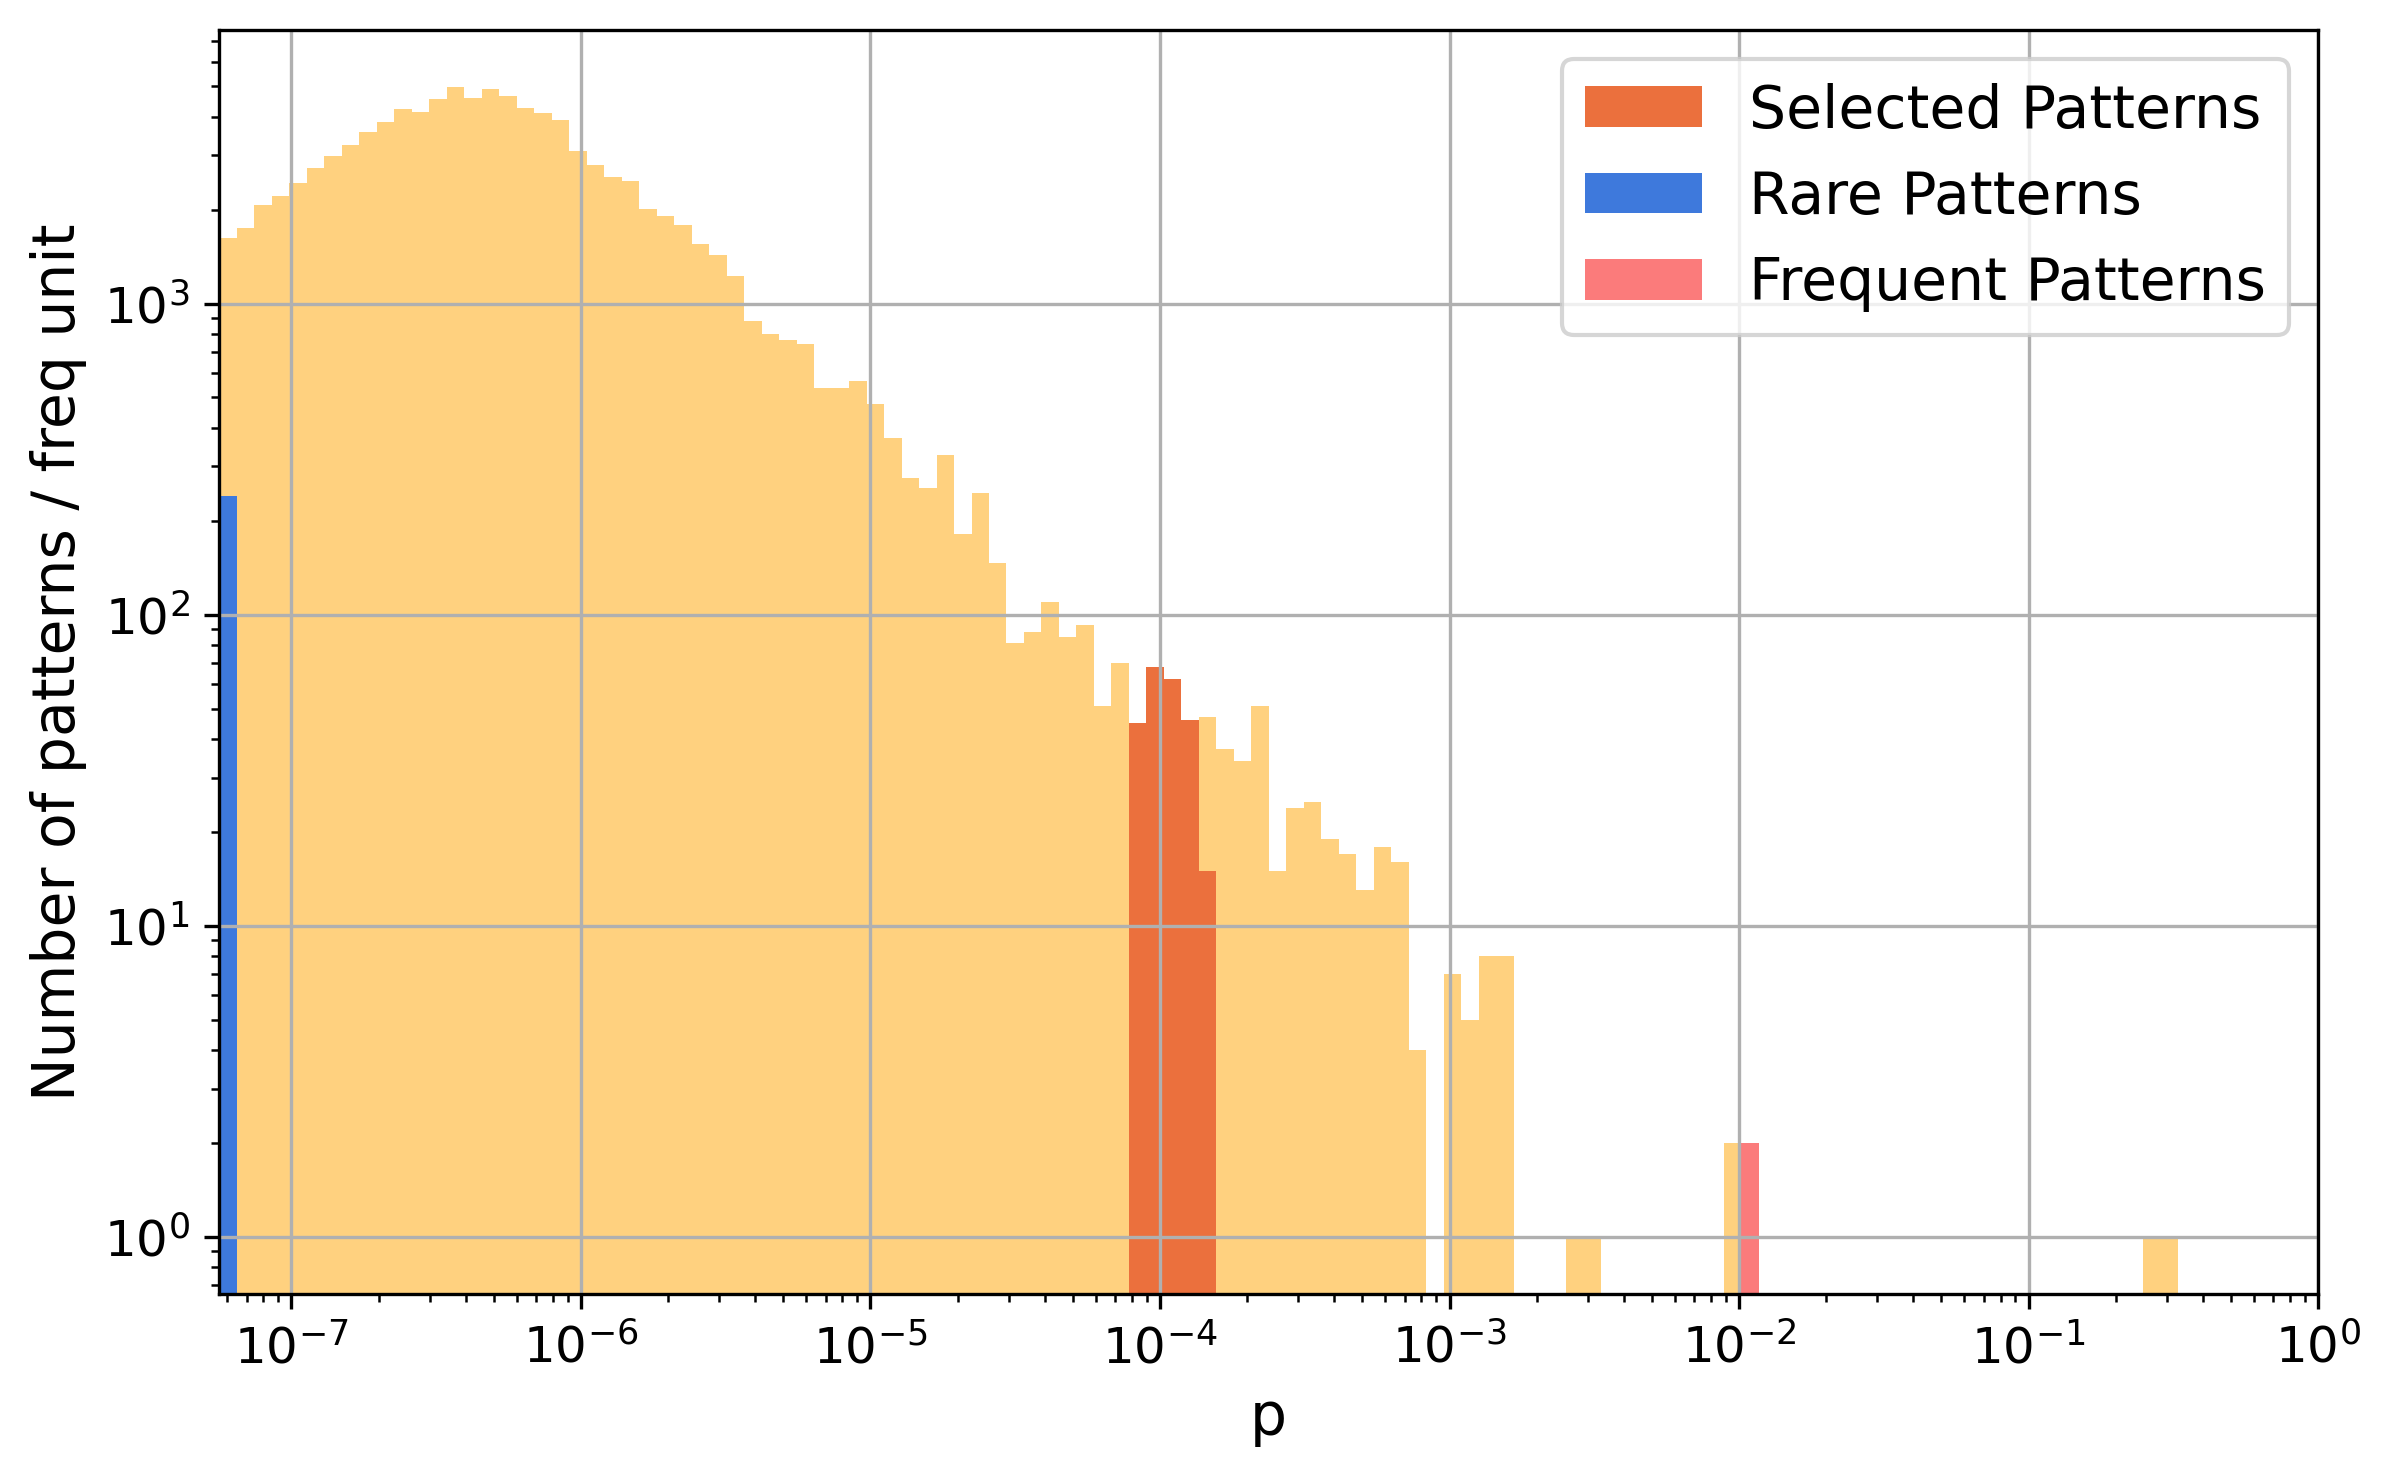

In [21]:


plt.figure(figsize=(8, 5), dpi=300)
bins = np.logspace(-9,0,150)

plt.hist(table["p"], bins = np.logspace(-9,0,150),alpha=0.5, color='orange')
plt.hist(table_eu[table_eu["Mask"]]["p"], bins =bins, color = "#eb703d", label = "Selected Patterns")
plt.hist(table_rari_match_N_W[table_rari_match_N_W["Mask"]]["p"], bins =bins, color = "#3e79dc", label = "Rare Patterns")
plt.hist(table_comuni_match_N_W[table_comuni_match_N_W["Mask"]]["p"], bins =bins, color = "#fb7b7b", label = "Frequent Patterns")
plt.xscale('log')
plt.yscale("log")
plt.xlabel("p", fontsize=14)
plt.ylabel("Number of patterns / freq unit", fontsize=14)
plt.xlim(table["p"].min(),1)
plt.grid(True)
plt.tight_layout()
plt.legend(fontsize = 14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()